In [36]:
import os
import numpy as np
import xarray as xr
from tqdm import tqdm

import torch
import torch.nn as nn

import mlflow
from mlflow import MlflowClient

import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

from Fires._datasets.torch_dataset import FireDataset
from Fires._macros.macros import (
	CREDENTIALS_CFG,
	DRIVERS,
	TARGETS,
	DATA_PATH_100KM,
	MAX_HECTARES_100KM,
	EXPS_PTH,
)
from Fires._plots.plot_utils import plot_dataset_map
from Fires._scalers.standard import StandardScaler
from Fires._models.unetpp import UnetPlusPlus
from Fires._utilities.metrics import TverskyLoss, FocalLoss


In [79]:
os.environ['MLFLOW_TRACKING_INSECURE_TLS'] = 'true'
os.environ['MLFLOW_TRACKING_USERNAME'] = CREDENTIALS_CFG.credentials.username
os.environ['MLFLOW_TRACKING_PASSWORD'] = CREDENTIALS_CFG.credentials.password

# set tracking uri
TRACKING_URI = 'https://mlflow.intertwin.fedcloud.eu/'
mlflow.set_tracking_uri(TRACKING_URI)

# specify run id and artifact uri
RUN_IDS = {
	'ml4f_upp_tv_128':'61a25325b06548489f173c7a054ce538',
	'ml4f_upp_tv_064':'e86786665dda403abd3905c7cdc884af',
	'ml4f_upp_tv_032':'09e787c181064b28a8699235c36aef17',
	'ml4f_upp_tv_016':'839d427f0aad435ab488b7b76898d27b',
	'ml4f_upp_tv_008':'16ae1379bd574a14b991f652b45fa657',
	'ml4f_upp_tv_004':'85fe7cac4662499f9265a7a5df962800',
}

RUN_ID = RUN_IDS['ml4f_upp_tv_128']
ARTIFACT_URI = 'model_weights' # f'mlflow-artifacts:/18/{RUN_ID}/artifacts/model_weights/last_model.pt'

# define local path and create it
local_path = os.path.join(os.getcwd(), 'MLFLOW', f"RUN_{RUN_ID}")
os.makedirs(local_path, exist_ok=True)

In [80]:
# define client and path to downloaded artifacts
client = MlflowClient()
# artifact_path = client.download_artifacts(run_id=RUN_ID, path=ARTIFACT_URI, dst_path=local_path)

In [81]:
model_uri = f'runs:/{RUN_ID}/last_model'

registered_model = mlflow.pytorch.load_model(model_uri, map_location=torch.device('mps'))
registered_model


2024/10/23 16:15:56 WARNING mlflow.pytorch: Stored model version '2.4.1+cu118' does not match installed PyTorch version '2.4.1'


UnetPlusPlus(
  (activation): Sigmoid()
  (pool_2x2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (pool_3x3): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (up_2x2): Upsample(scale_factor=(2.0, 2.0), mode='bilinear')
  (up_3x3): Upsample(scale_factor=(3.0, 3.0), mode='bilinear')
  (conv0_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(7, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv1_0): VGGBlock(
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (co

In [82]:

# load features
drivers, targets = DRIVERS, TARGETS
print(drivers, "\n", targets)

# define path to complete dataset
DS_PATH = DATA_PATH_100KM
print(DS_PATH)

# open the dataset and choose a subset
dataset = xr.open_zarr(DS_PATH)[drivers + targets].load()
test_data = dataset.sel(time=slice('2019', '2020'))

# load the land sea mask and substitute zeros with NaN values
lsm = test_data.lsm.mean(dim='time', skipna=True).values
lsm[lsm == 0] = np.nan
print(lsm.shape)

# define MAX_HECT_LSM_MAP as global
MAX_HECT_LSM_MAP = lsm * MAX_HECTARES_100KM
print(MAX_HECT_LSM_MAP)

# define latitudes and longitudes
lats = dataset.latitude.values
lons = dataset.longitude.values
print(f"Latitude count: {len(lats)} \t Longitude count: {len(lons)}")

['lai', 'lst_day', 'rel_hum', 'sst', 't2m_min', 'tp', 'lsm'] 
 ['fcci_ba']
/Users/edonno/VSCode/CMCC/ML4Fires/data/data_100km.zarr
(180, 360)
[[     nan      nan      nan ...      nan      nan      nan]
 [     nan      nan      nan ...      nan      nan      nan]
 [     nan      nan      nan ...      nan      nan      nan]
 ...
 [1232100. 1232100. 1232100. ... 1232100. 1232100. 1232100.]
 [1232100. 1232100. 1232100. ... 1232100. 1232100. 1232100.]
 [1232100. 1232100. 1232100. ... 1232100. 1232100. 1232100.]]
Latitude count: 180 	 Longitude count: 360


In [83]:
# define trianing dataset
ds_trn = dataset.sel(time=slice('2001', '2016'))

# compute mean along time, latitude and longitude axes
mean_ds = ds_trn.mean(dim=['time','latitude', 'longitude'], skipna=True)

# compute standard deviation along time, latitude and longitude axes
stdv_ds = ds_trn.std(dim=['time','latitude', 'longitude'], skipna=True)

# define scaler
x_scaler = StandardScaler(mean_ds=mean_ds, stdv_ds=stdv_ds, features=drivers)

In [84]:
# define torch dataset
torch_dataset = FireDataset(
	src=DS_PATH,
	drivers=drivers,
	targets=targets,
	years=list(range(2019,2021)),
	scalers=[x_scaler, None]
)

In [85]:
# define torch data loader
torch_data_loader = torch.utils.data.DataLoader(
	torch_dataset,
	batch_size=1,
	shuffle=True,
	drop_last=True
)

In [86]:
preds = []
with torch.no_grad():
	for data, _ in tqdm(torch_data_loader):
		prediction = registered_model(data.to('mps'))
		prediction_cpu = prediction.cpu().numpy()
		preds.append(prediction_cpu)
preds_array = np.vstack(preds)

100%|██████████| 92/92 [00:22<00:00,  4.07it/s]


In [87]:
def compute_aggregated_data(data, other_data=None, operation="mean") -> tuple[np.ndarray, np.ndarray, np.ndarray]:
	"""
	Compute the mean or difference between data, and aggregate along latitudes and longitudes

	Parameters
	----------
	data : numpy.ndarray
	 	Input data, can be unscaled or already scaled and masked depending on the operation to be performed
	other_data : numpy.ndarray, optional
	 	Optional input data for calculating the difference, also assumed to be scaled and masked
		Required if `operation` is 'diff'.
	operation : str
		Operation to perform ("mean" for mean, "diff" for difference)

	Returns
	-------
	tuple of np.ndarray
		A tuple containing:
			- data : np.ndarray
				Scaled and masked data after the operation.
			- descaled_on_lats : np.ndarray
				Mean of data along latitudes.
			- descaled_on_lons : np.ndarray
				Mean of data along longitudes.
	
	Raises
	------
	ValueError
		If `operation` is 'diff' and `other_data` is not provided.

	"""

	# define function name

	data = data.copy()

	if operation == "diff":
		if other_data is None:
			raise ValueError("other_data must be provided when operation is 'diff'")
		# difference between data that has been masked and rescaled to the original size
		data -= other_data
	else:
		# mask data with the land sea mask and rescale to original size
		data *= MAX_HECT_LSM_MAP

	descaled_on_lats = np.nanmean(data, axis=1)
	descaled_on_lons = np.nanmean(data, axis=0)

	print(f" {operation.capitalize()} of data: {data.shape}")
	print(f" Max: {round(np.nanmax(data), 2)} \t Min: {round(np.nanmin(data), 2)}")
	print(f" Lats Max: {round(np.nanmax(descaled_on_lats), 2)} \t Lons Max: {round(np.nanmax(descaled_on_lons), 2)}")

	return data, descaled_on_lats, descaled_on_lons


def up_and_lower_bounds(avg_value, std_value):
	"""
	Compute upper and lower bound values.

	Parameters
	----------
	avg_value : np.ndarray or float
		The average values.
	std_value : np.ndarray or float
		The standard deviation values.

	Returns
	-------
	tuple
		A tuple containing the upper bound and lower bound values.

	"""

	_upper = avg_value + std_value
	_lower = avg_value - std_value
	return _upper, _lower


def process_and_plot_data(data, label, lats, lons, model_name):
	"""
	Process the data and generate plots.

	Parameters
	----------
	data : xarray.DataArray or np.ndarray
		Data to process; can be an xarray.DataArray for real data or a numpy.ndarray for predictions.
	label : str
		Label to use in the plot title.
	lats : np.ndarray
		Array of latitudes.
	lons : np.ndarray
		Array of longitudes.
	model_name : str
		Name of the model, used in the plot title.

	"""
	
	# Verify data type and compute mean and standard deviation along time axis
	if isinstance(data, xr.DataArray):
		avg_on_time = data.mean(dim='time', skipna=True).data
		std_on_time = data.std(dim='time', skipna=True).data
		print(f"Is DataArray - AVG: {avg_on_time.shape} STD: {std_on_time.shape}")
	else:
		avg_on_time = np.nanmean(data, axis=0)[0, ...]
		std_on_time = np.nanstd(data, axis=0)[0, ...]
		print(f"NOT DataArray - AVG: {avg_on_time.shape} STD: {std_on_time.shape}")

	# Aggregate data
	avg_descaled, avg_on_lats, _ = compute_aggregated_data(data=avg_on_time)
	_, std_on_lats, _ = compute_aggregated_data(data=std_on_time)

	# Compute upper and lower boundaries
	upperbound, lowerbound = up_and_lower_bounds(avg_value=avg_on_lats, std_value=std_on_lats)

	# Plot data
	plot_dataset_map(
		avg_target_data=avg_descaled,
		avg_data_on_lats=avg_on_lats,
		lowerbound_data=lowerbound,
		upperbound_data=upperbound,
		lats=lats,
		lons=lons,
		title=f'{label} ({model_name.upper()})',
		cmap='nipy_spectral_r'
	)


/Users/edonno/VSCode/CMCC/ML4Fires/ML4F_venv/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/5s/30crgp4s335_jp4cpx_j42d00000gp/T/ipykernel_13450/3511033737.py:46: RuntimeWarning: Mean of empty slice
  descaled_on_lats = np.nanmean(data, axis=1)


Is DataArray - AVG: (180, 360) STD: (180, 360)
 Mean of data: (180, 360)
 Max: 5135.48 	 Min: 0.0
 Lats Max: 1027.5 	 Lons Max: 539.6
 Mean of data: (180, 360)
 Max: 13253.32 	 Min: 0.0
 Lats Max: 1883.89 	 Lons Max: 1051.82


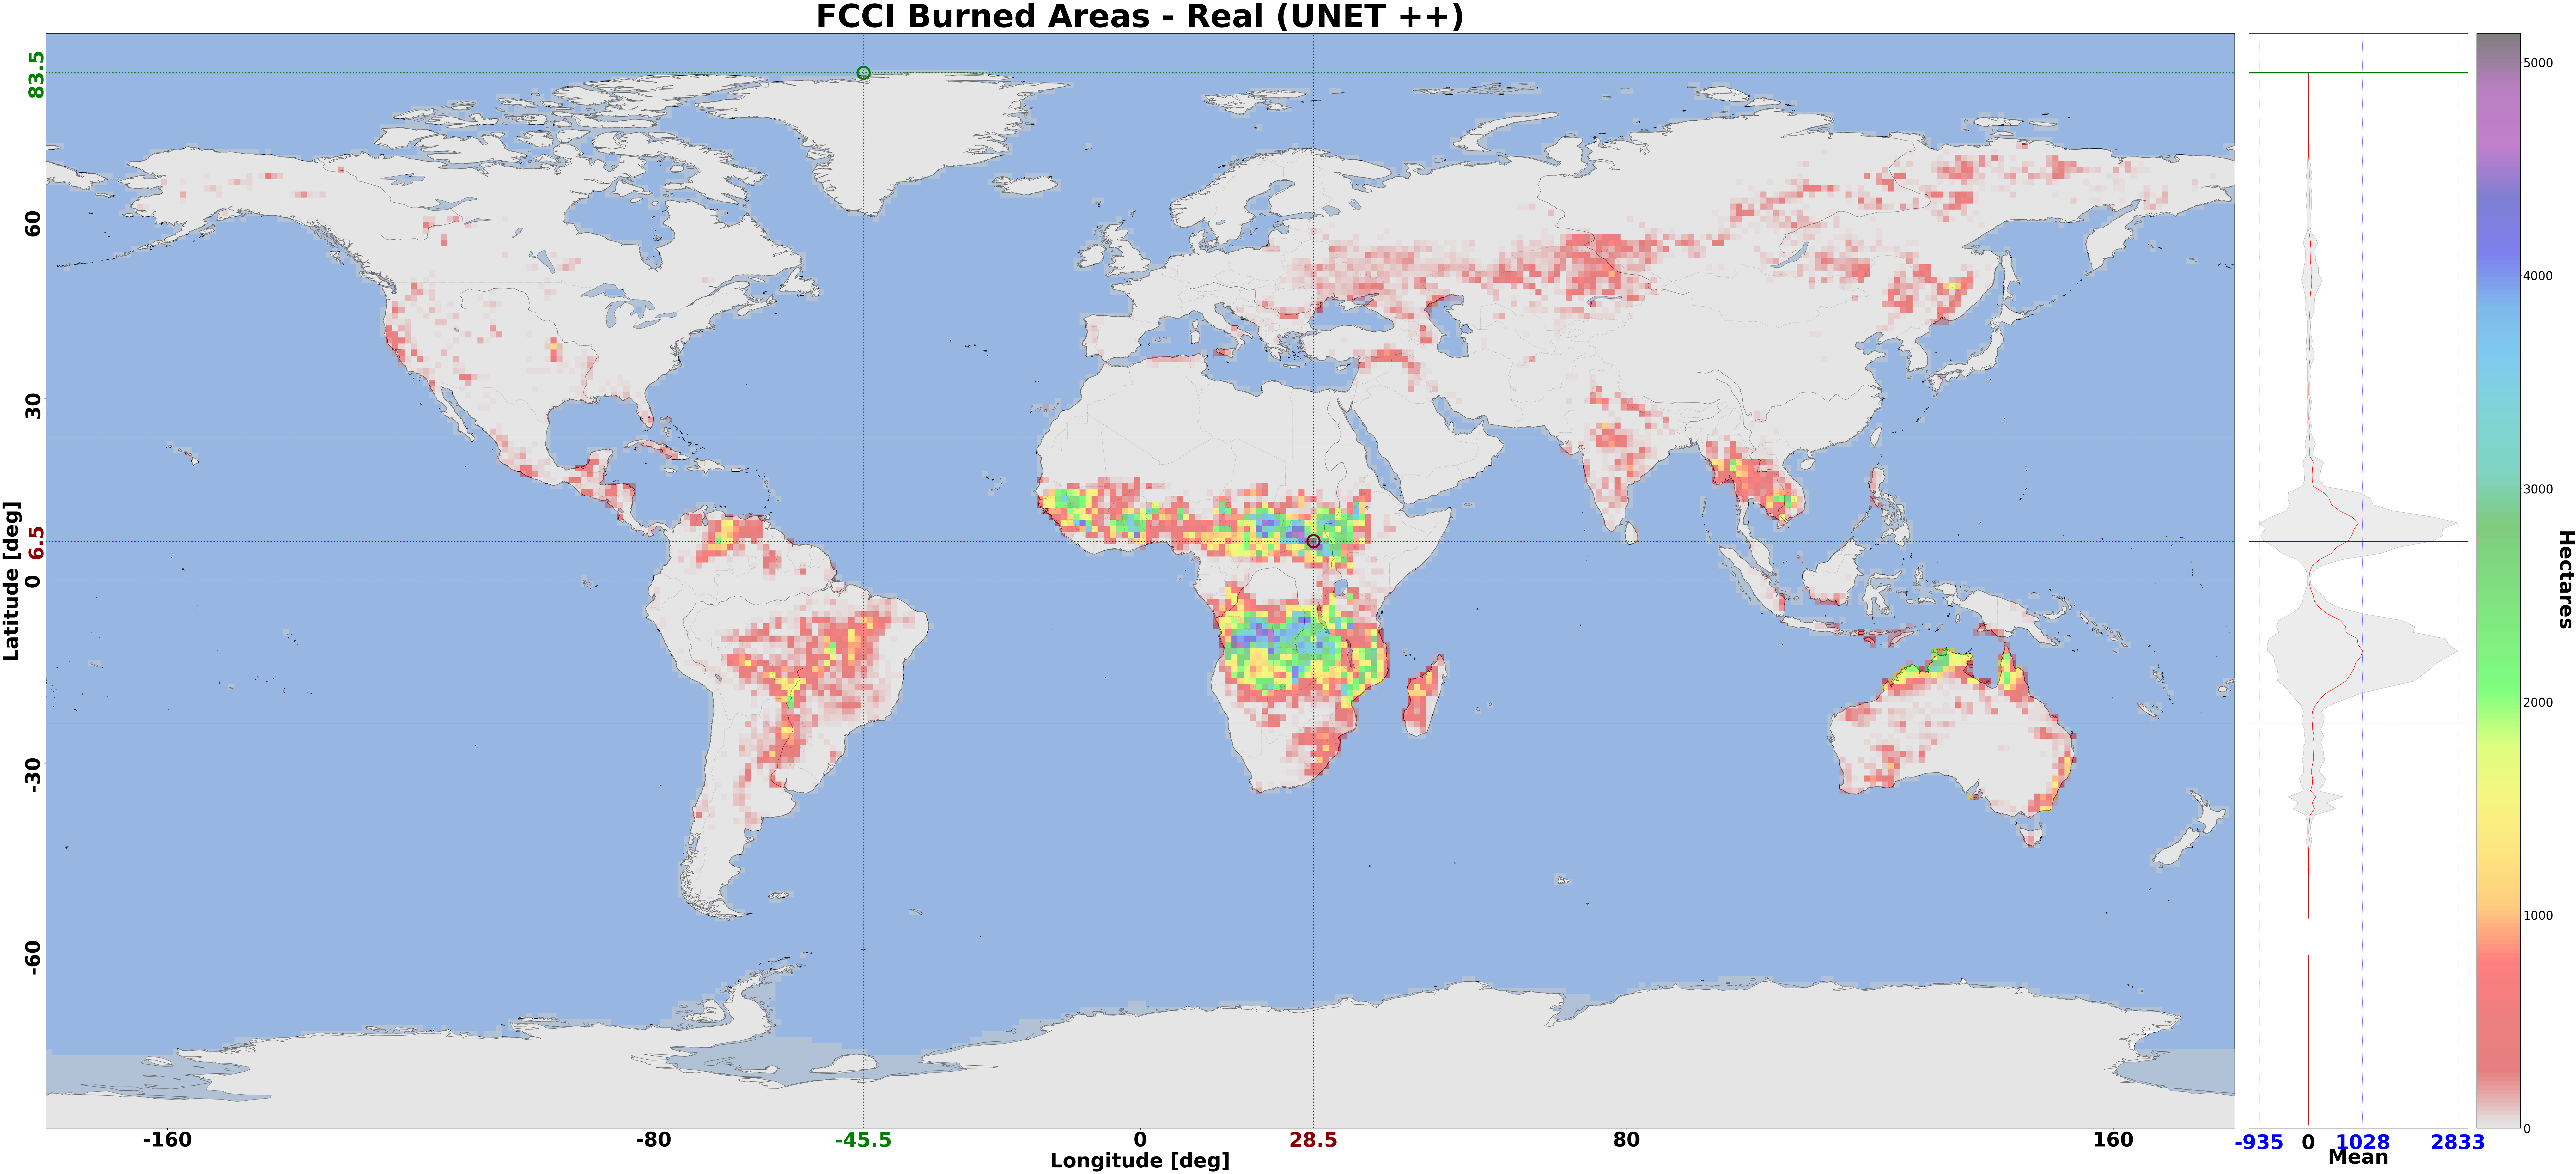

In [88]:
process_and_plot_data(
	data=test_data.fcci_ba,
	label='FCCI Burned Areas - Real',
	lats=lats,
	lons=lons,
	model_name="Unet ++"
)

In [89]:
preds_descaled = [p*MAX_HECT_LSM_MAP for p in preds_array]
np.nanmin(preds_descaled[0]), np.nanmax(preds_descaled[0])

(1.974745951889458e-20, 1232100.0)

NOT DataArray - AVG: (180, 360) STD: (180, 360)
 Mean of data: (180, 360)
 Max: 1231960.875 	 Min: 0.0
 Lats Max: 463286.375 	 Lons Max: 246813.375
 Mean of data: (180, 360)
 Max: 616045.5625 	 Min: 0.0
 Lats Max: 446858.625 	 Lons Max: 275979.71875


/var/folders/5s/30crgp4s335_jp4cpx_j42d00000gp/T/ipykernel_13450/3511033737.py:46: RuntimeWarning: Mean of empty slice
  descaled_on_lats = np.nanmean(data, axis=1)


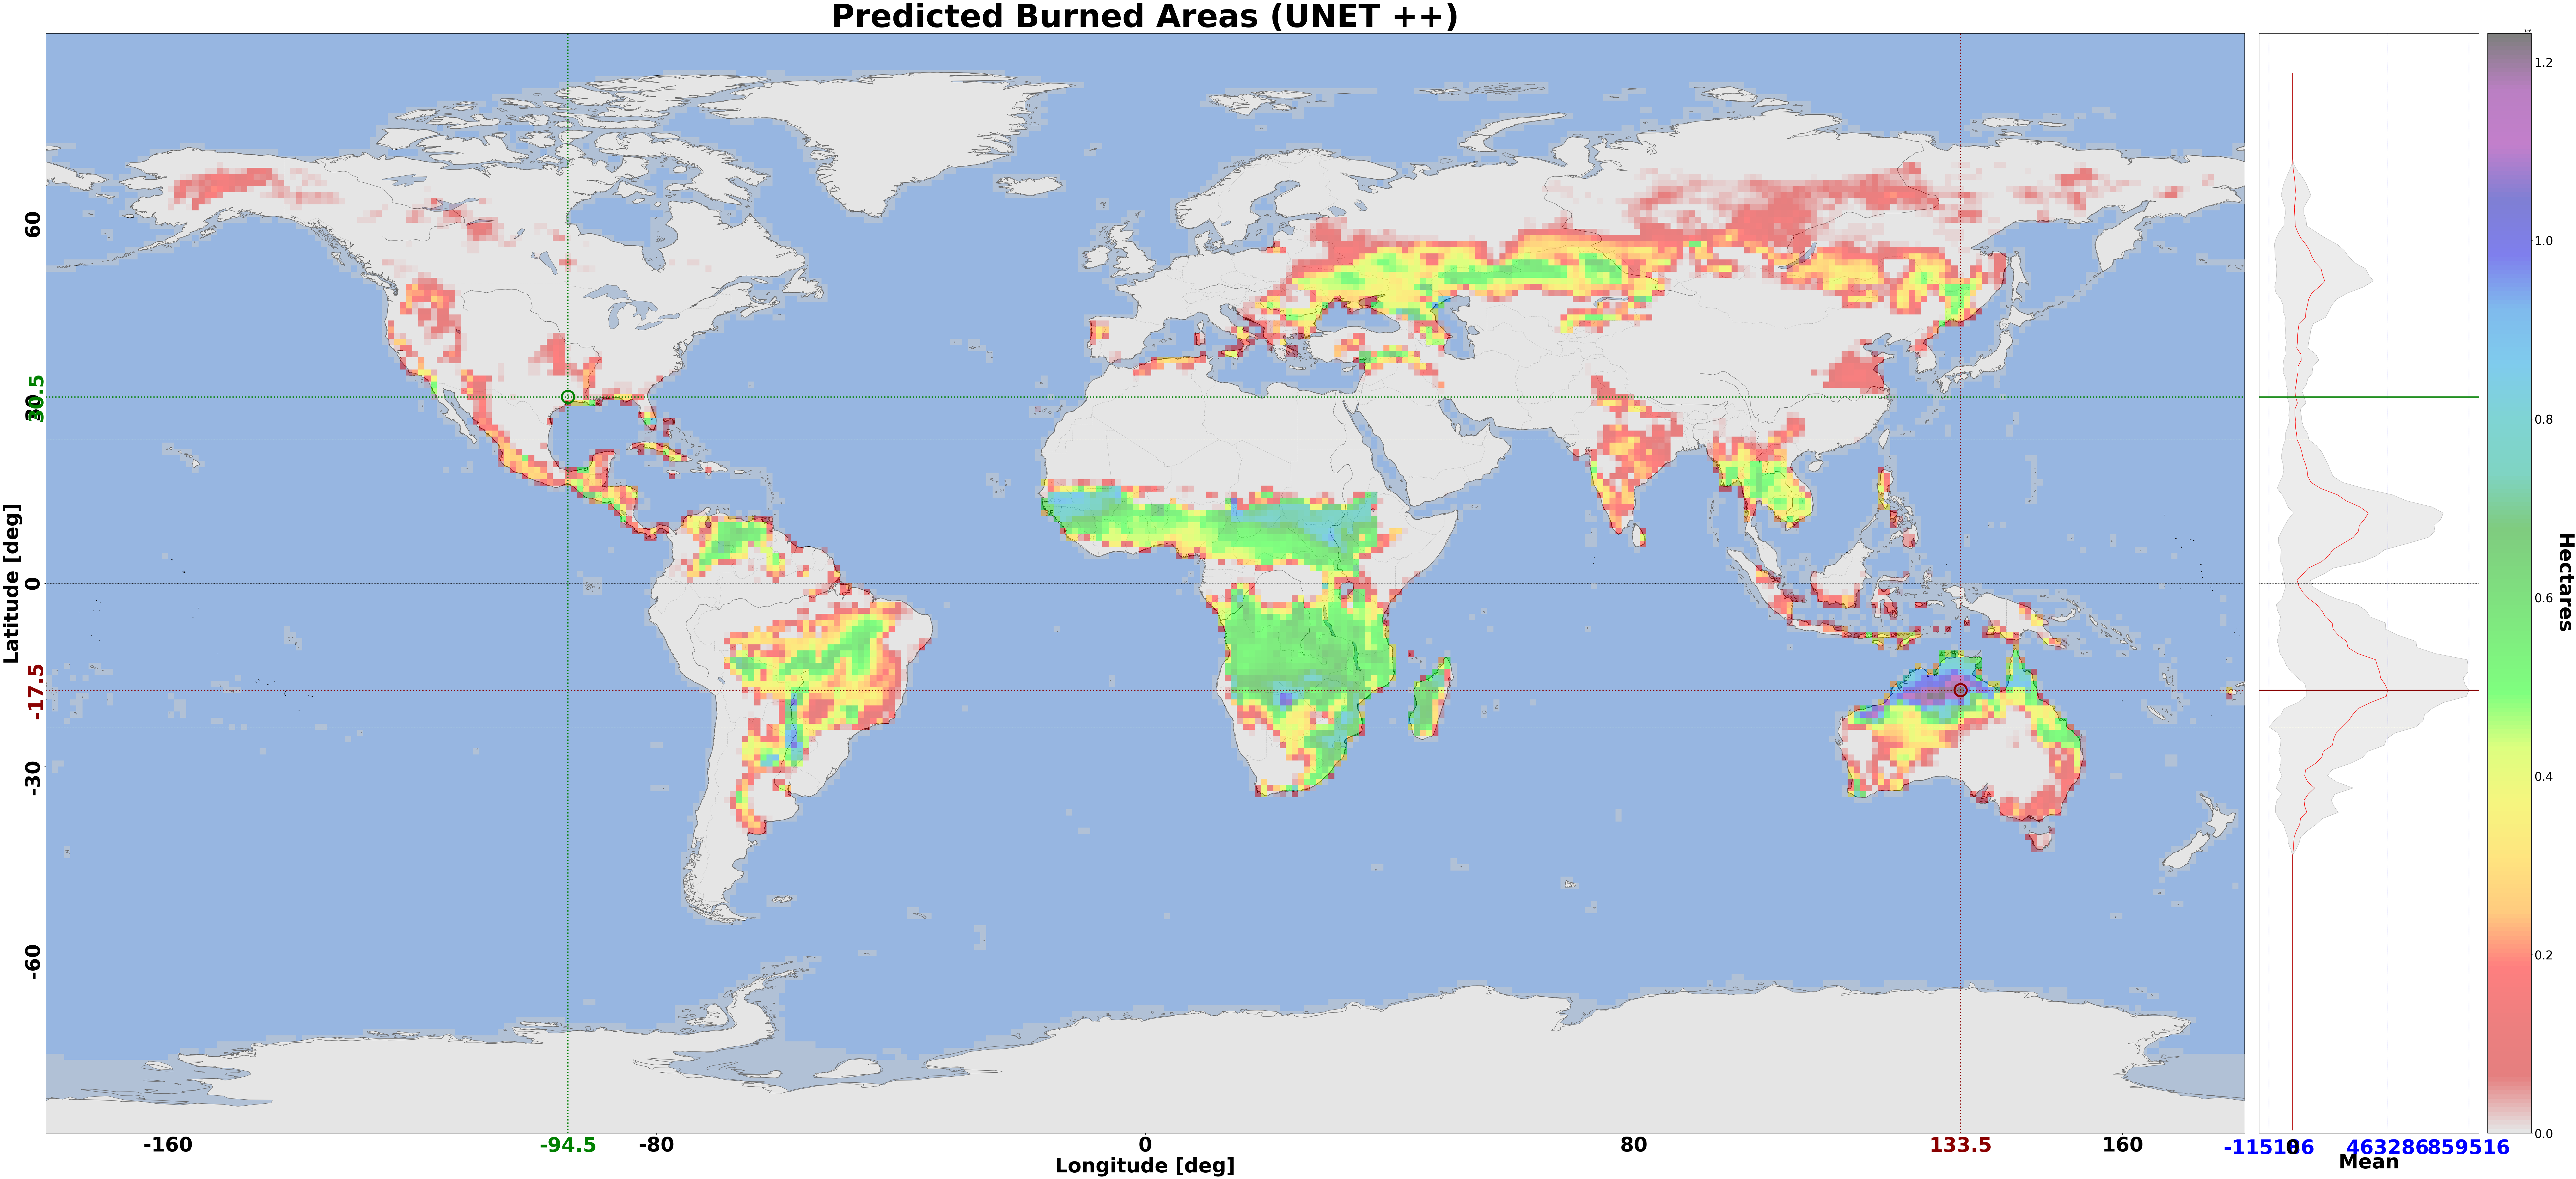

In [90]:
process_and_plot_data(
	data=preds_array,
	label='Predicted Burned Areas',
	lats=lats,
	lons=lons,
	model_name="Unet ++"
)